Actual directory:  c:\Users\rpork\Desktop\Documenti\Studio\MAGISTRALE\Machine Learning\GTZAN_Genre_Recognizer
Find install_missing_libraries = True in config.json
Missing libraries will be installed automatically
Check if data exists at the following path:  data\genres
All subfolders found
Number of tracks founds:
blues     : 100
classical : 100
country   : 100
disco     : 100
hiphop    : 100
jazz      : 100
metal     : 100
pop       : 100
reggae    : 100
rock      : 100
Total tracks: 1000


Extracting features: 100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Feature matrix shape: (1000, 75)
Labels array shape: (1000,)
Saved in data\genres file X_features.npy and y_labels.npy
X_features shape: (1000, 75)
y_labels shape: (1000,)
Unique labels: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Train size: 700
Validation size: 150
Test size: 150

=== Training knn ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV accuracy: 0.68
Best params: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}

=== Training svm_rbf ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV accuracy: 0.7328571428571429
Best params: {'clf__C': 10, 'clf__gamma': 0.01}

=== Training rf ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV accuracy: 0.7071428571428571
Best params: {'clf__max_depth': 10, 'clf__n_estimators': 200}

--- KNN on Validation ---
Accuracy: 0.7133333333333334
              precision    recall  f1-score   support

       blues      0.733     0.733     0.7

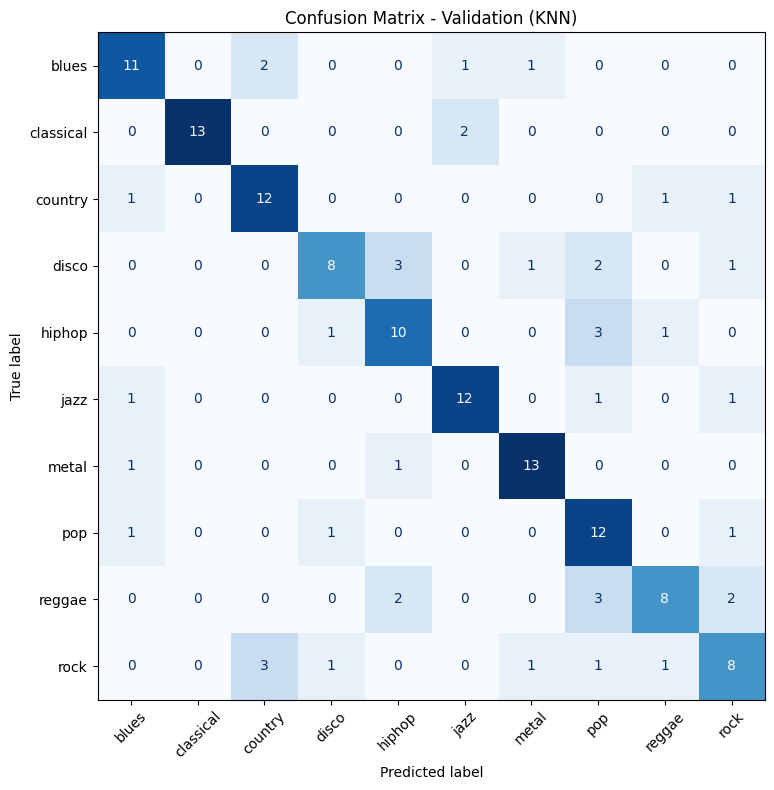


=== SVM_RBF on Validation Set ===
Accuracy: 0.8133333333333334
Precision (macro): 0.8230679863652
Recall (macro):    0.8133333333333335
F1-score (macro):  0.8085107944793541

Classification Report:
              precision    recall  f1-score   support

       blues      0.824     0.933     0.875        15
   classical      1.000     0.933     0.966        15
     country      0.722     0.867     0.788        15
       disco      0.818     0.600     0.692        15
      hiphop      0.789     1.000     0.882        15
        jazz      0.933     0.933     0.933        15
       metal      0.917     0.733     0.815        15
         pop      0.667     0.933     0.778        15
      reggae      0.833     0.667     0.741        15
        rock      0.727     0.533     0.615        15

    accuracy                          0.813       150
   macro avg      0.823     0.813     0.809       150
weighted avg      0.823     0.813     0.809       150



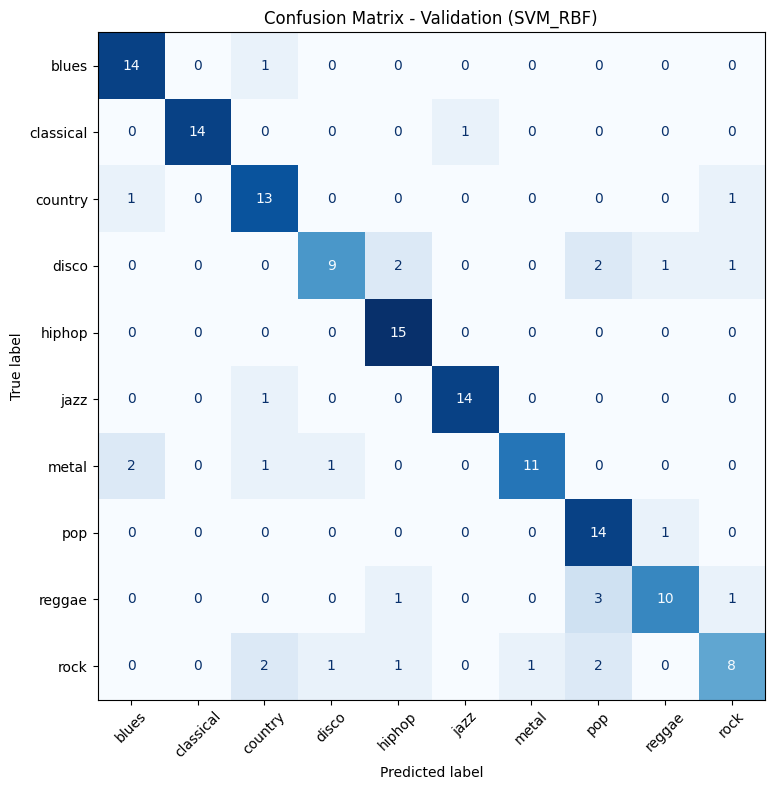


=== RF on Validation Set ===
Accuracy: 0.78
Precision (macro): 0.7875920484744016
Recall (macro):    0.78
F1-score (macro):  0.7792366972108352

Classification Report:
              precision    recall  f1-score   support

       blues      0.800     0.800     0.800        15
   classical      1.000     0.933     0.966        15
     country      0.786     0.733     0.759        15
       disco      0.556     0.667     0.606        15
      hiphop      0.650     0.867     0.743        15
        jazz      0.882     1.000     0.938        15
       metal      0.929     0.867     0.897        15
         pop      0.923     0.800     0.857        15
      reggae      0.714     0.667     0.690        15
        rock      0.636     0.467     0.538        15

    accuracy                          0.780       150
   macro avg      0.788     0.780     0.779       150
weighted avg      0.788     0.780     0.779       150



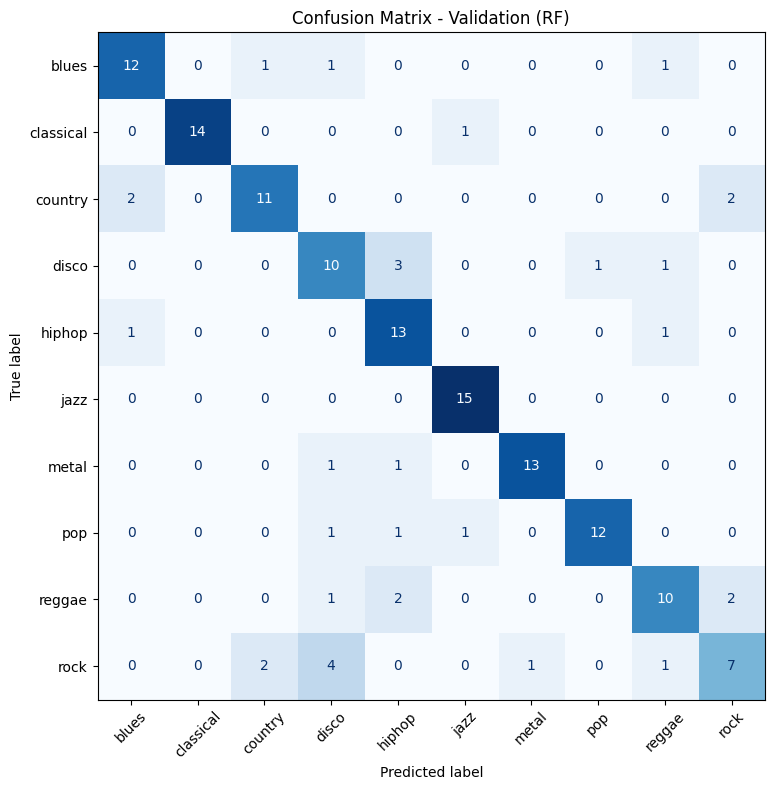

Dataset loaded: (1000, 75) (1000,)
Loaded best model:  models\best_model_svm_rbf.joblib
Test set size: 150
Test Accuracy: 0.82
              precision    recall  f1-score   support

       blues      0.812     0.867     0.839        15
   classical      1.000     0.933     0.966        15
     country      0.667     0.800     0.727        15
       disco      0.750     0.600     0.667        15
      hiphop      0.812     0.867     0.839        15
        jazz      0.833     1.000     0.909        15
       metal      0.929     0.867     0.897        15
         pop      0.867     0.867     0.867        15
      reggae      0.800     0.800     0.800        15
        rock      0.750     0.600     0.667        15

    accuracy                          0.820       150
   macro avg      0.822     0.820     0.818       150
weighted avg      0.822     0.820     0.818       150



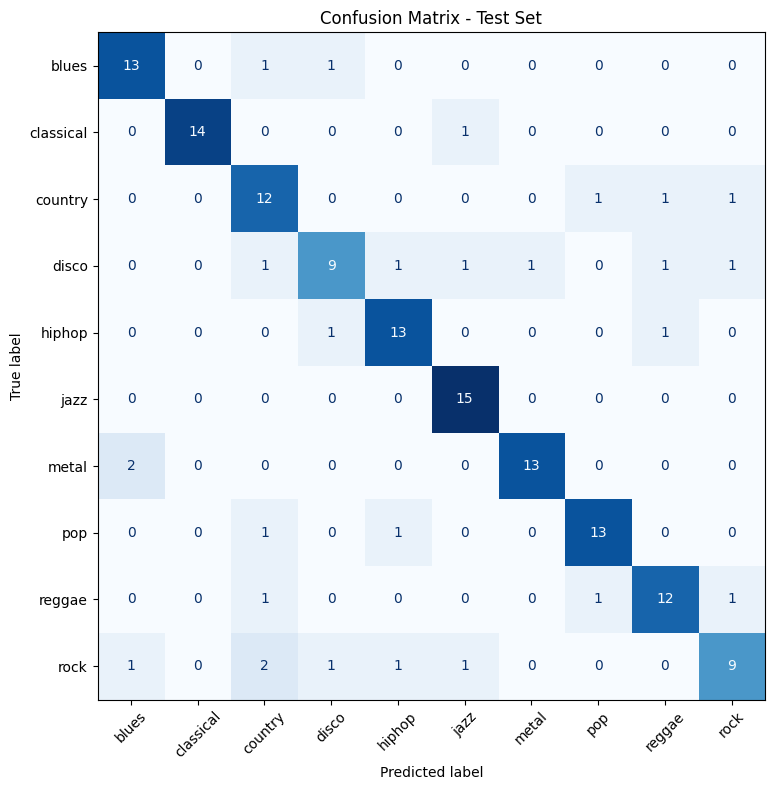

           Precision    Recall  F1-score
Genre                                   
blues       0.812500  0.866667  0.838710
classical   1.000000  0.933333  0.965517
country     0.666667  0.800000  0.727273
disco       0.750000  0.600000  0.666667
hiphop      0.812500  0.866667  0.838710
jazz        0.833333  1.000000  0.909091
metal       0.928571  0.866667  0.896552
pop         0.866667  0.866667  0.866667
reggae      0.800000  0.800000  0.800000
rock        0.750000  0.600000  0.666667


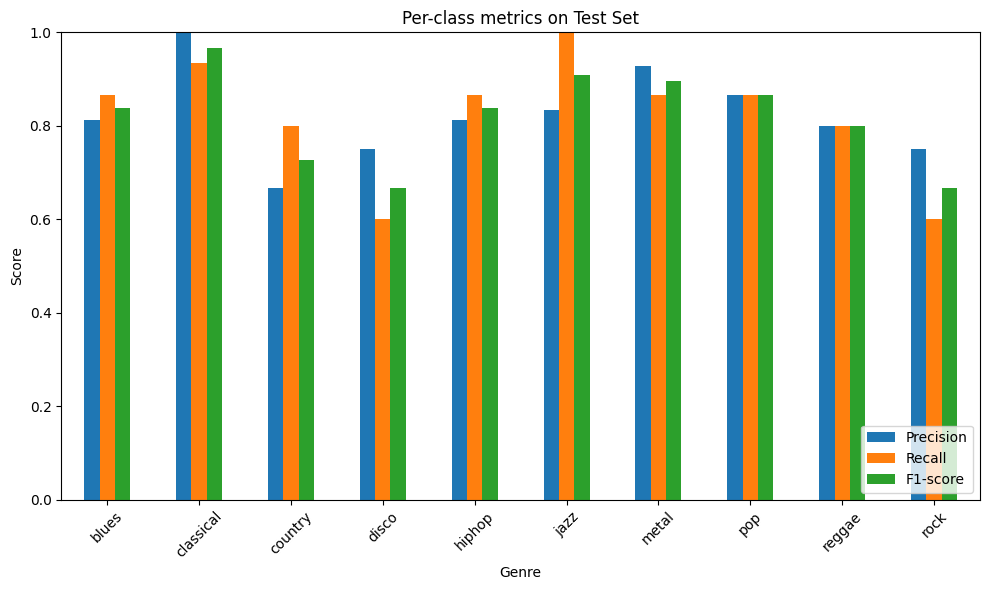

Loaded best model:  models\best_model_svm_rbf.joblib


c:\Users\rpork\Desktop\Documenti\Studio\MAGISTRALE\Machine Learning\GTZAN_Genre_Recognizer\src\feature_extraction.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
C:\Users\rpork\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'data\\genres\\rock\\rock.00055.wav'

FileNotFoundError: [Errno 2] No such file or directory: 'data\\genres\\rock\\rock.00055.wav'

In [ ]:
import json
import os
from pathlib import Path
from src.os_path_management import adapt_path, check_os

# STEP 0: Open config.json
file_config_path = Path(os.path.join(os.getcwd(), 'config.json'))
assert file_config_path.exists(), "File config.json not found"
with open(file_config_path, "r", encoding="utf-8") as f:
    config = json.load(f)

DATA_DIR = adapt_path(config["data_dir"])                            # str: data/genres
DOWNLOAD_MISSING_DATASET = config["download_missing_dataset"]        # bool
FEATURES_DIR = adapt_path(config["features_dir"])                    # str: data/features
GENRES = config["genres"]                                            # list[str]
INSTALL_MISSING_LIBRARIES = config["install_missing_libraries"]      # bool
LIBRARIES = config["libraries"]                                      # list[str]
RECALCULATE_FEATURES_ALWAYS = config["recalculate_features_always"]  # bool

# STEP 2: Check the current working directory and validate it with an assertion
CHECK_OS = check_os()
SYSTEM_DETECTED = CHECK_OS[0]
assert SYSTEM_DETECTED, CHECK_OS[1]

# Check pwd directory
print("Actual directory: ", os.getcwd())
assert os.path.basename(os.getcwd()) == "GTZAN_Genre_Recognizer", "The script should be starded from root-project folder with GTZAN_Genre_Recognizer name"

script_path = os.path.join(os.getcwd(), "src")
script_download_missing_library = os.path.join(script_path, "download_missing_library.py")
script_download_data = os.path.join(script_path, "download_data.py")

FEATURES_FILE_NAME = "X_features.npy"
LABELS_FILE_NAME = "y_labels.npy"
FEATURES_PATH = os.path.join(FEATURES_DIR, FEATURES_FILE_NAME)
LABELS_PATH = os.path.join(FEATURES_DIR, LABELS_FILE_NAME)

# STEP 1: Check mandatory libraries to run the notebooks
print(f"Find install_missing_libraries = {INSTALL_MISSING_LIBRARIES} in config.json")
if INSTALL_MISSING_LIBRARIES:
    print(f"Missing libraries will be installed automatically")
else:
    print(f"Missing libraries will not be installed automatically")

for pkg in LIBRARIES:
    try:
        __import__(pkg)
    except ImportError:
        if INSTALL_MISSING_LIBRARIES:
            print(f"Installing {pkg}")
            !python "{script_download_missing_library}" {pkg}
        else:
            raise ImportError(f"Mandatory library not found: {pkg}."
                              f"Run the following command to install it: pip install {pkg} or set install_missing_libraries = true in config.json")

#DATASET_EXTENSION = "au"

# STEP 3: Run all the notebooks in sequence
##TODO: Test download_data.py and invoke it when dataset is not valid - test missing
%run notebooks/01_data_setup.ipynb    # Prepare Dataset

if RECALCULATE_FEATURES_ALWAYS or (not os.path.exists(FEATURES_PATH) and not os.path.exists(LABELS_PATH)): # Check configuration RECALCULATE_FEATURES_ALWAYS == True or if features already exist
    %run notebooks/02_features.ipynb  # Feature Extraction
else:
    print(f"Found {FEATURES_DIR}/{FEATURES_FILE_NAME} and {LABELS_FILE_NAME}, skipping notebooks/02_features.ipynb")

BEST_MODEL_PREFIX = config["best_model_prefix"]
CROSS_VALIDATION_FOLDS_NUMBER = config["cross_validation_folds_number"]
RANDOM_STATE = config["random_state"]
%run notebooks/03_training.ipynb      # Training and Model Selection

%run notebooks/04_evaluation.ipynb    # Final Evaluation on Test Set

#%run notebooks/05_inference.ipynb     # Inference on New Audio Files